## 1. Setup and Imports

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
from typing import Dict, List


# Import the environment and agents
from permuted_mnist.env.permuted_mnist import PermutedMNISTEnv
#from permuted_mnist.agent_r1.agent_v1 import Agent as AgentR1

print("✓ Imports successful")

✓ Imports successful


## 2. Create the Environment

Let's create an environment with 10 different permuted tasks:

In [ ]:
# Create environment with 10 episodes (tasks)
env = PermutedMNISTEnv(number_episodes=10)

# Set seed for reproducibility
env.set_seed(42)

print(f"Environment created with {env.number_episodes} permuted tasks")
print(f"Training set size: {env.train_size} samples")
print(f"Test set size: {env.test_size} samples")

Environment created with 10 permuted tasks
Training set size: 60000 samples
Test set size: 10000 samples


## 3. Understanding the Task Structure

Let's examine what a single task looks like:

In [50]:
# Get the first task
task = env.get_next_task()

print("Task structure:")
print(f"- X_train shape: {task['X_train'].shape}")
print(f"- y_train shape: {task['y_train'].shape}")
print(f"- X_test shape: {task['X_test'].shape}")
print(f"- y_test shape: {task['y_test'].shape}")
print(f"\nLabel distribution in training set:")
unique, counts = np.unique(task['y_train'], return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Label {label}: {count} samples")

Task structure:
- X_train shape: (60000, 28, 28)
- y_train shape: (60000, 1)
- X_test shape: (10000, 28, 28)
- y_test shape: (10000,)

Label distribution in training set:
  Label 0: 6131 samples
  Label 1: 6742 samples
  Label 2: 5421 samples
  Label 3: 5851 samples
  Label 4: 6265 samples
  Label 5: 5958 samples
  Label 6: 5949 samples
  Label 7: 5842 samples
  Label 8: 5923 samples
  Label 9: 5918 samples


## 4. Visualize Permuted Images

Let's see how the permutation affects the images:

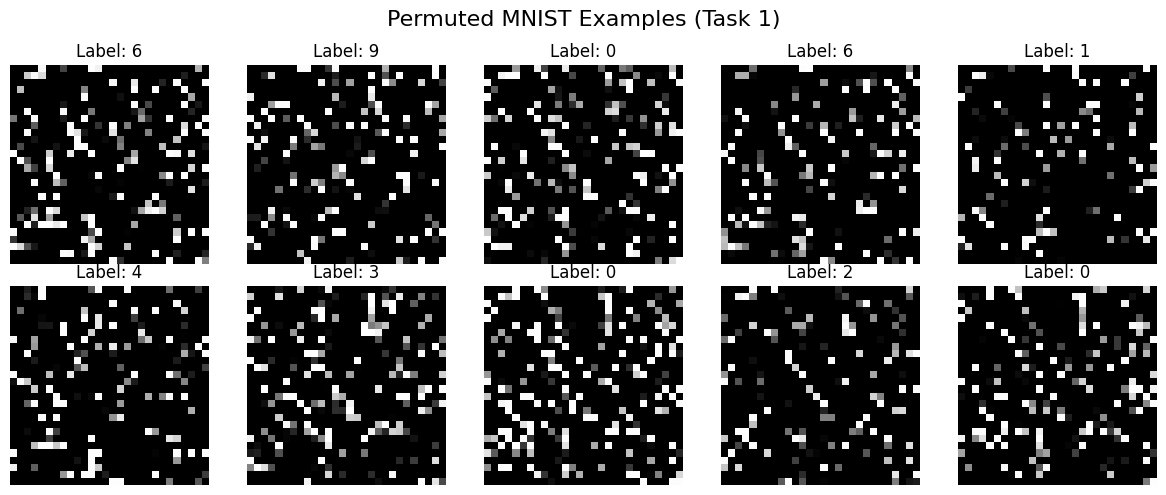

Note: The images look scrambled due to pixel permutation!
The labels are also permuted (not the original MNIST labels).


In [41]:

# Display some examples from the permuted task
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Permuted MNIST Examples (Task 1)', fontsize=16)

for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(task['X_train'][i], cmap='gray')
    ax.set_title(f'Label: {task["y_train"][i][0]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

print("Note: The images look scrambled due to pixel permutation!")
print("The labels are also permuted (not the original MNIST labels).")



## A. Création des agents

In [62]:
# ================== IMPORTS ==================
import torch
from torch import nn


# ================== UTILS ====================
ACTS = {
    "relu": nn.ReLU,
    "gelu": nn.GELU,
    "tanh": nn.Tanh,
    "leaky_relu": nn.LeakyReLU,
    "sigmoid": nn.Sigmoid,  
    None: nn.Identity,
}

def build_mlp(
    input_dim=28*28,
    hidden_layers=(512, 256),
    activation="relu",
    use_batchnorm=False,    
    dropout=0.0,
    output_dim=10,
):
    layers, d = [], input_dim
    Act = ACTS[activation]
    for h in hidden_layers:
        layers.append(nn.Linear(d, h))
        if use_batchnorm:
            layers.append(nn.BatchNorm1d(h))
        layers.append(Act())
        if dropout and dropout > 0:
            layers.append(nn.Dropout(dropout))
        d = h
    layers.append(nn.Linear(d, output_dim))
    return nn.Sequential(*layers)

class FlexibleMLP(nn.Module):
    def __init__(
        self,
        input_dim=28*28,
        hidden_layers=(512, 256),
        activation="relu",
        use_batchnorm=False,
        dropout=0.0,
        output_dim=10,
    ):
        super().__init__()
        self.net = build_mlp(
            input_dim=input_dim,
            hidden_layers=hidden_layers,
            activation=activation,
            use_batchnorm=use_batchnorm,
            dropout=dropout,
            output_dim=output_dim,
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten
        return self.net(x)

OPTIMS = {
    "adam": torch.optim.Adam,
    "sgd": torch.optim.SGD,
    "adamw": torch.optim.AdamW,
    "rmsprop": torch.optim.RMSprop,
}

def build_optimizer(model, name="adam", lr=1e-3, weight_decay=0.0, momentum=0.9):
    name = name.lower()
    if name == "sgd":
        return OPTIMS[name](model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    return OPTIMS[name](model.parameters(), lr=lr, weight_decay=weight_decay)

# ================== AGENT ====================
class Agent:
    """
    Agent générique: on fournit deux builders
    - model_builder() -> nn.Module
    - optim_builder(model) -> torch.optim.Optimizer
    """
    def __init__(
        self,
        output_dim=10,
        seed=None,
        model_builder=lambda: FlexibleMLP(),
        optim_builder=lambda m: build_optimizer(m, "adam", 1e-3),
        batch_size=1024,
        max_epochs=2,
        val_fraction=0.1,
        num_threads=2,
        time_budget_s=60.0,
        verbose=False,
    ):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed); np.random.seed(seed)
        torch.set_num_threads(num_threads)

        self.model_builder = model_builder
        self.optim_builder = optim_builder
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.val_fraction = val_fraction
        self.time_budget_s = time_budget_s
        self.verbose = verbose

        self.model = self.model_builder()
        self.loss_fn = nn.CrossEntropyLoss()

    def reset(self):
        self.model = self.model_builder()

    def _to_tensor(self, X, y=None):
        X = torch.from_numpy(X).float().div_(255.0)
        if y is None:
            return X
        if y.ndim > 1:
            y = y.squeeze()
        y = torch.from_numpy(y).long()
        return X, y

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        # shuffle + split validation
        N = X_train.shape[0]
        idx = np.random.permutation(N)
        N_val = int(self.val_fraction * N)
        val_idx, tr_idx = idx[:N_val], idx[N_val:]

        X_tr, y_tr = self._to_tensor(X_train[tr_idx], y_train[tr_idx])
        X_val, y_val = self._to_tensor(X_train[val_idx], y_train[val_idx])

        opt = self.optim_builder(self.model)
        start = time.time()
        self.model.train()

        for ep in range(self.max_epochs):
            perm = torch.randperm(X_tr.size(0))
            for i in range(0, X_tr.size(0), self.batch_size):
                b = perm[i:i+self.batch_size]
                xb, yb = X_tr[b], y_tr[b]
                opt.zero_grad()
                logits = self.model(xb)
                loss = self.loss_fn(logits, yb)
                loss.backward()
                opt.step()

                if time.time() - start > self.time_budget_s:
                    break

            if self.verbose:
                self.model.eval()
                with torch.no_grad():
                    val_logits = self.model(X_val)
                    val_acc = (val_logits.argmax(1).cpu().numpy() == y_val.cpu().numpy()).mean()
                self.model.train()
                print(f"[ep {ep}] val_acc={val_acc:.3f}")

            if time.time() - start > self.time_budget_s:
                break

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        X = self._to_tensor(X_test)
        self.model.eval()
        with torch.no_grad():
            logits = self.model(X)
        return logits.argmax(1).cpu().numpy()

# ================== GRIDS ====================
arch_grid = [
    dict(hidden_layers=(256,),              activation="relu", use_batchnorm=False, dropout=0.0),
    dict(hidden_layers=(768,),              activation="gelu", use_batchnorm=False, dropout=0.0),
    dict(hidden_layers=(256, 256),          activation="relu", use_batchnorm=False, dropout=0.1),
    dict(hidden_layers=(512, 256),          activation="gelu", use_batchnorm=False, dropout=0.1),
    dict(hidden_layers=(768, 512),          activation="relu", use_batchnorm=False, dropout=0.1),
    dict(hidden_layers=(512, 512),          activation="gelu", use_batchnorm=False, dropout=0.1),
    dict(hidden_layers=(1024, 512),         activation="relu", use_batchnorm=False, dropout=0.1),
    dict(hidden_layers=(512, 512, 256),     activation="gelu", use_batchnorm=False, dropout=0.1),
    dict(hidden_layers=(256, 256, 256),     activation="tanh", use_batchnorm=False, dropout=0.0),
    dict(hidden_layers=(768, 768),          activation="relu", use_batchnorm=False, dropout=0.1),
    dict(hidden_layers=(512, 512, 512),     activation="relu", use_batchnorm=False, dropout=0.2),
    dict(hidden_layers=(1024,),             activation="gelu", use_batchnorm=False, dropout=0.1),
]

optim_grid = [
    dict(name="adamw",  lr=1e-3, weight_decay=1e-4),
    dict(name="adamw",  lr=7e-4, weight_decay=5e-4),
    dict(name="adamw",  lr=3e-4, weight_decay=1e-4),
    dict(name="adam",   lr=1e-3, weight_decay=0.0),
    dict(name="sgd",    lr=3e-2, weight_decay=0.0, momentum=0.9),
    dict(name="rmsprop",lr=1e-3, weight_decay=0.0),
]

def make_model_builder(arch_cfg):
    return lambda: FlexibleMLP(
        input_dim=28*28,
        hidden_layers=arch_cfg["hidden_layers"],
        activation=arch_cfg["activation"],
        use_batchnorm=arch_cfg["use_batchnorm"],
        dropout=arch_cfg["dropout"],
        output_dim=10,
    )
def make_optim_builder(opt_cfg):
    return lambda model: build_optimizer(
        model,
        name=opt_cfg["name"],
        lr=opt_cfg["lr"],
        weight_decay=opt_cfg.get("weight_decay", 0.0),
        momentum=opt_cfg.get("momentum", 0.9),
    )

# ================== RUNNER ===================
env = PermutedMNISTEnv(number_episodes=10)     
env.set_seed(42)                                 

t_start_all = time.time()
results = []

for arch_cfg in arch_grid:
    for opt_cfg in optim_grid:
        env.reset(); env.set_seed(42)

        t_start = time.time()
        agent = Agent(
            seed=42,
            model_builder=make_model_builder(arch_cfg),
            optim_builder=make_optim_builder(opt_cfg),
            batch_size=1024,
            max_epochs=2,
            time_budget_s=60.0,
        )

        accs, times = [], []
        while True:
            task = env.get_next_task()
            if task is None:
                break
            agent.reset()
            t0 = time.time()
            agent.train(task["X_train"], task["y_train"])
            preds = agent.predict(task["X_test"])
            elapsed = time.time() - t0
            acc = env.evaluate(preds, task["y_test"])
            accs.append(acc); times.append(elapsed)

        t_elapsed = time.time() - t_start
        mean_acc = float(np.mean(accs))

        results.append({
            "arch": arch_cfg,
            "opt": opt_cfg,
            "mean_acc": mean_acc,
            "std_acc": float(np.std(accs)),
            "total_time": float(np.sum(times)),
            "full_runtime": t_elapsed,
        })

        print(f"→ {arch_cfg} {opt_cfg} mean_acc={mean_acc:.5f} "
              f"| total_time(10)={t_elapsed:.2f}s "
              f"({np.mean(times):.2f}s/task)")

t_total_all = time.time() - t_start_all
print(f"\n🏁 Grid search complet terminé en {t_total_all/60:.1f} minutes.")


→ {'hidden_layers': (256,), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.0} {'name': 'adamw', 'lr': 0.001, 'weight_decay': 0.0001} mean_acc=0.92132 | total_time(10)=7.69s (0.57s/task)
→ {'hidden_layers': (256,), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.0} {'name': 'adamw', 'lr': 0.0007, 'weight_decay': 0.0005} mean_acc=0.91437 | total_time(10)=6.87s (0.50s/task)
→ {'hidden_layers': (256,), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.0} {'name': 'adamw', 'lr': 0.0003, 'weight_decay': 0.0001} mean_acc=0.88786 | total_time(10)=6.76s (0.50s/task)
→ {'hidden_layers': (256,), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.0} {'name': 'adam', 'lr': 0.001, 'weight_decay': 0.0} mean_acc=0.92137 | total_time(10)=6.60s (0.48s/task)
→ {'hidden_layers': (256,), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.0} {'name': 'sgd', 'lr': 0.03, 'weight_decay': 0.0, 'momentum': 0.9} mean_acc=0.90107 | total_time(10)=6.46s (0.47s/task)
→

## B. Historiques des configs testés avec leur résultats 


### **Première grilles testé:**
arch_grid = [
    dict(hidden_layers=(256,),              activation="relu", use_batchnorm=False, dropout=0.0),
    dict(hidden_layers=(768,),              activation="gelu", use_batchnorm=False, dropout=0.0),
    dict(hidden_layers=(256, 256),          activation="relu", use_batchnorm=False, dropout=0.1),
    dict(hidden_layers=(512, 256),          activation="gelu", use_batchnorm=False, dropout=0.1),
    dict(hidden_layers=(768, 512),          activation="relu", use_batchnorm=False, dropout=0.1),
    dict(hidden_layers=(512, 512),          activation="gelu", use_batchnorm=False, dropout=0.1),
    dict(hidden_layers=(1024, 512),         activation="relu", use_batchnorm=False, dropout=0.1),
    dict(hidden_layers=(512, 512, 256),     activation="gelu", use_batchnorm=False, dropout=0.1),
    dict(hidden_layers=(256, 256, 256),     activation="tanh", use_batchnorm=False, dropout=0.0),
    dict(hidden_layers=(768, 768),          activation="relu", use_batchnorm=False, dropout=0.1),
    dict(hidden_layers=(512, 512, 512),     activation="relu", use_batchnorm=False, dropout=0.2),
    dict(hidden_layers=(1024,),             activation="gelu", use_batchnorm=False, dropout=0.1),
]

optim_grid = [
    dict(name="adamw",  lr=1e-3, weight_decay=1e-4),
    dict(name="adamw",  lr=7e-4, weight_decay=5e-4),
    dict(name="adamw",  lr=3e-4, weight_decay=1e-4),
    dict(name="adam",   lr=1e-3, weight_decay=0.0),
    dict(name="sgd",    lr=3e-2, weight_decay=0.0, momentum=0.9),
    dict(name="rmsprop",lr=1e-3, weight_decay=0.0),
]


### **Résulats :**
→ {'hidden_layers': (256,), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.0} {'name': 'adamw', 'lr': 0.001, 'weight_decay': 0.0001} mean_acc=0.92132 | total_time(10)=7.69s (0.57s/task)
→ {'hidden_layers': (256,), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.0} {'name': 'adamw', 'lr': 0.0007, 'weight_decay': 0.0005} mean_acc=0.91437 | total_time(10)=6.87s (0.50s/task)
→ {'hidden_layers': (256,), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.0} {'name': 'adamw', 'lr': 0.0003, 'weight_decay': 0.0001} mean_acc=0.88786 | total_time(10)=6.76s (0.50s/task)
→ {'hidden_layers': (256,), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.0} {'name': 'adam', 'lr': 0.001, 'weight_decay': 0.0} mean_acc=0.92137 | total_time(10)=6.60s (0.48s/task)
→ {'hidden_layers': (256,), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.0} {'name': 'sgd', 'lr': 0.03, 'weight_decay': 0.0, 'momentum': 0.9} mean_acc=0.90107 | total_time(10)=6.46s (0.47s/task)
→ {'hidden_layers': (256,), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.0} {'name': 'rmsprop', 'lr': 0.001, 'weight_decay': 0.0} mean_acc=0.93209 | total_time(10)=6.47s (0.47s/task)
→ {'hidden_layers': (768,), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.0} {'name': 'adamw', 'lr': 0.001, 'weight_decay': 0.0001} mean_acc=0.92918 | total_time(10)=13.86s (1.20s/task)
→ {'hidden_layers': (768,), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.0} {'name': 'adamw', 'lr': 0.0007, 'weight_decay': 0.0005} mean_acc=0.92238 | total_time(10)=13.68s (1.18s/task)
→ {'hidden_layers': (768,), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.0} {'name': 'adamw', 'lr': 0.0003, 'weight_decay': 0.0001} mean_acc=0.90619 | total_time(10)=13.37s (1.16s/task)
→ {'hidden_layers': (768,), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.0} {'name': 'adam', 'lr': 0.001, 'weight_decay': 0.0} mean_acc=0.92918 | total_time(10)=13.32s (1.15s/task)
→ {'hidden_layers': (768,), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.0} {'name': 'sgd', 'lr': 0.03, 'weight_decay': 0.0, 'momentum': 0.9} mean_acc=0.89772 | total_time(10)=12.46s (1.07s/task)
→ {'hidden_layers': (768,), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.0} {'name': 'rmsprop', 'lr': 0.001, 'weight_decay': 0.0} mean_acc=0.93784 | total_time(10)=13.13s (1.13s/task)
→ {'hidden_layers': (256, 256), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adamw', 'lr': 0.001, 'weight_decay': 0.0001} mean_acc=0.93324 | total_time(10)=10.69s (0.89s/task)
→ {'hidden_layers': (256, 256), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adamw', 'lr': 0.0007, 'weight_decay': 0.0005} mean_acc=0.92466 | total_time(10)=10.66s (0.89s/task)
→ {'hidden_layers': (256, 256), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adamw', 'lr': 0.0003, 'weight_decay': 0.0001} mean_acc=0.90461 | total_time(10)=10.76s (0.89s/task)
→ {'hidden_layers': (256, 256), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adam', 'lr': 0.001, 'weight_decay': 0.0} mean_acc=0.93333 | total_time(10)=10.55s (0.87s/task)
→ {'hidden_layers': (256, 256), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'sgd', 'lr': 0.03, 'weight_decay': 0.0, 'momentum': 0.9} mean_acc=0.89686 | total_time(10)=10.35s (0.85s/task)
→ {'hidden_layers': (256, 256), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'rmsprop', 'lr': 0.001, 'weight_decay': 0.0} mean_acc=0.94585 | total_time(10)=10.36s (0.86s/task)
→ {'hidden_layers': (512, 256), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adamw', 'lr': 0.001, 'weight_decay': 0.0001} mean_acc=0.93836 | total_time(10)=17.05s (1.52s/task)
→ {'hidden_layers': (512, 256), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adamw', 'lr': 0.0007, 'weight_decay': 0.0005} mean_acc=0.93052 | total_time(10)=16.70s (1.49s/task)
→ {'hidden_layers': (512, 256), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adamw', 'lr': 0.0003, 'weight_decay': 0.0001} mean_acc=0.91230 | total_time(10)=17.93s (1.60s/task)
→ {'hidden_layers': (512, 256), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adam', 'lr': 0.001, 'weight_decay': 0.0} mean_acc=0.93836 | total_time(10)=19.27s (1.73s/task)
→ {'hidden_layers': (512, 256), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'sgd', 'lr': 0.03, 'weight_decay': 0.0, 'momentum': 0.9} mean_acc=0.88123 | total_time(10)=18.35s (1.63s/task)
→ {'hidden_layers': (512, 256), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'rmsprop', 'lr': 0.001, 'weight_decay': 0.0} mean_acc=0.94291 | total_time(10)=18.53s (1.66s/task)
→ {'hidden_layers': (768, 512), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adamw', 'lr': 0.001, 'weight_decay': 0.0001} mean_acc=0.94857 | total_time(10)=26.65s (2.46s/task)
→ {'hidden_layers': (768, 512), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adamw', 'lr': 0.0007, 'weight_decay': 0.0005} mean_acc=0.94042 | total_time(10)=24.97s (2.30s/task)
→ {'hidden_layers': (768, 512), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adamw', 'lr': 0.0003, 'weight_decay': 0.0001} mean_acc=0.92289 | total_time(10)=23.75s (2.17s/task)
→ {'hidden_layers': (768, 512), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adam', 'lr': 0.001, 'weight_decay': 0.0} mean_acc=0.94853 | total_time(10)=24.53s (2.26s/task)
→ {'hidden_layers': (768, 512), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'sgd', 'lr': 0.03, 'weight_decay': 0.0, 'momentum': 0.9} mean_acc=0.90256 | total_time(10)=24.89s (2.28s/task)
→ {'hidden_layers': (768, 512), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'rmsprop', 'lr': 0.001, 'weight_decay': 0.0} mean_acc=0.95538 | total_time(10)=23.96s (2.20s/task)
→ {'hidden_layers': (512, 512), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adamw', 'lr': 0.001, 'weight_decay': 0.0001} mean_acc=0.94216 | total_time(10)=22.66s (2.07s/task)
→ {'hidden_layers': (512, 512), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adamw', 'lr': 0.0007, 'weight_decay': 0.0005} mean_acc=0.93255 | total_time(10)=23.34s (2.13s/task)
→ {'hidden_layers': (512, 512), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adamw', 'lr': 0.0003, 'weight_decay': 0.0001} mean_acc=0.91537 | total_time(10)=22.71s (2.07s/task)
→ {'hidden_layers': (512, 512), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adam', 'lr': 0.001, 'weight_decay': 0.0} mean_acc=0.94216 | total_time(10)=22.67s (2.07s/task)
→ {'hidden_layers': (512, 512), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'sgd', 'lr': 0.03, 'weight_decay': 0.0, 'momentum': 0.9} mean_acc=0.88213 | total_time(10)=20.61s (1.87s/task)
→ {'hidden_layers': (512, 512), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'rmsprop', 'lr': 0.001, 'weight_decay': 0.0} mean_acc=0.94458 | total_time(10)=24.97s (2.28s/task)
→ {'hidden_layers': (1024, 512), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adamw', 'lr': 0.001, 'weight_decay': 0.0001} mean_acc=0.95272 | total_time(10)=38.49s (3.61s/task)
→ {'hidden_layers': (1024, 512), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adamw', 'lr': 0.0007, 'weight_decay': 0.0005} mean_acc=0.94528 | total_time(10)=39.55s (3.63s/task)
→ {'hidden_layers': (1024, 512), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adamw', 'lr': 0.0003, 'weight_decay': 0.0001} mean_acc=0.92727 | total_time(10)=39.47s (3.69s/task)
→ {'hidden_layers': (1024, 512), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adam', 'lr': 0.001, 'weight_decay': 0.0} mean_acc=0.95282 | total_time(10)=37.75s (3.51s/task)
→ {'hidden_layers': (1024, 512), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'sgd', 'lr': 0.03, 'weight_decay': 0.0, 'momentum': 0.9} mean_acc=0.90405 | total_time(10)=25.93s (2.41s/task)
→ {'hidden_layers': (1024, 512), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'rmsprop', 'lr': 0.001, 'weight_decay': 0.0} mean_acc=0.95640 | total_time(10)=27.11s (2.53s/task)
→ {'hidden_layers': (512, 512, 256), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adamw', 'lr': 0.001, 'weight_decay': 0.0001} mean_acc=0.94585 | total_time(10)=23.52s (2.16s/task)
→ {'hidden_layers': (512, 512, 256), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adamw', 'lr': 0.0007, 'weight_decay': 0.0005} mean_acc=0.93645 | total_time(10)=25.86s (2.38s/task)
→ {'hidden_layers': (512, 512, 256), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adamw', 'lr': 0.0003, 'weight_decay': 0.0001} mean_acc=0.91412 | total_time(10)=29.81s (2.75s/task)
→ {'hidden_layers': (512, 512, 256), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adam', 'lr': 0.001, 'weight_decay': 0.0} mean_acc=0.94585 | total_time(10)=30.52s (2.82s/task)
→ {'hidden_layers': (512, 512, 256), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'sgd', 'lr': 0.03, 'weight_decay': 0.0, 'momentum': 0.9} mean_acc=0.52435 | total_time(10)=25.05s (2.30s/task)
→ {'hidden_layers': (512, 512, 256), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'rmsprop', 'lr': 0.001, 'weight_decay': 0.0} mean_acc=0.93926 | total_time(10)=23.97s (2.21s/task)
→ {'hidden_layers': (256, 256, 256), 'activation': 'tanh', 'use_batchnorm': False, 'dropout': 0.0} {'name': 'adamw', 'lr': 0.001, 'weight_decay': 0.0001} mean_acc=0.93399 | total_time(10)=10.34s (0.85s/task)
→ {'hidden_layers': (256, 256, 256), 'activation': 'tanh', 'use_batchnorm': False, 'dropout': 0.0} {'name': 'adamw', 'lr': 0.0007, 'weight_decay': 0.0005} mean_acc=0.92701 | total_time(10)=10.02s (0.82s/task)
→ {'hidden_layers': (256, 256, 256), 'activation': 'tanh', 'use_batchnorm': False, 'dropout': 0.0} {'name': 'adamw', 'lr': 0.0003, 'weight_decay': 0.0001} mean_acc=0.90495 | total_time(10)=10.30s (0.84s/task)
→ {'hidden_layers': (256, 256, 256), 'activation': 'tanh', 'use_batchnorm': False, 'dropout': 0.0} {'name': 'adam', 'lr': 0.001, 'weight_decay': 0.0} mean_acc=0.93399 | total_time(10)=11.49s (0.94s/task)
→ {'hidden_layers': (256, 256, 256), 'activation': 'tanh', 'use_batchnorm': False, 'dropout': 0.0} {'name': 'sgd', 'lr': 0.03, 'weight_decay': 0.0, 'momentum': 0.9} mean_acc=0.89790 | total_time(10)=11.31s (0.93s/task)
→ {'hidden_layers': (256, 256, 256), 'activation': 'tanh', 'use_batchnorm': False, 'dropout': 0.0} {'name': 'rmsprop', 'lr': 0.001, 'weight_decay': 0.0} mean_acc=0.91686 | total_time(10)=11.57s (0.95s/task)
→ {'hidden_layers': (768, 768), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adamw', 'lr': 0.001, 'weight_decay': 0.0001} mean_acc=0.95204 | total_time(10)=30.14s (2.81s/task)
→ {'hidden_layers': (768, 768), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adamw', 'lr': 0.0007, 'weight_decay': 0.0005} mean_acc=0.94438 | total_time(10)=25.54s (2.37s/task)
→ {'hidden_layers': (768, 768), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adamw', 'lr': 0.0003, 'weight_decay': 0.0001} mean_acc=0.92683 | total_time(10)=25.76s (2.39s/task)
→ {'hidden_layers': (768, 768), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adam', 'lr': 0.001, 'weight_decay': 0.0} mean_acc=0.95213 | total_time(10)=27.54s (2.56s/task)
→ {'hidden_layers': (768, 768), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'sgd', 'lr': 0.03, 'weight_decay': 0.0, 'momentum': 0.9} mean_acc=0.90385 | total_time(10)=26.88s (2.49s/task)
→ {'hidden_layers': (768, 768), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'rmsprop', 'lr': 0.001, 'weight_decay': 0.0} mean_acc=0.95748 | total_time(10)=31.00s (2.88s/task)
→ {'hidden_layers': (512, 512, 512), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.2} {'name': 'adamw', 'lr': 0.001, 'weight_decay': 0.0001} mean_acc=0.95146 | total_time(10)=29.18s (2.70s/task)
→ {'hidden_layers': (512, 512, 512), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.2} {'name': 'adamw', 'lr': 0.0007, 'weight_decay': 0.0005} mean_acc=0.94339 | total_time(10)=29.46s (2.73s/task)
→ {'hidden_layers': (512, 512, 512), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.2} {'name': 'adamw', 'lr': 0.0003, 'weight_decay': 0.0001} mean_acc=0.92104 | total_time(10)=25.46s (2.36s/task)
→ {'hidden_layers': (512, 512, 512), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.2} {'name': 'adam', 'lr': 0.001, 'weight_decay': 0.0} mean_acc=0.95125 | total_time(10)=23.79s (2.19s/task)
→ {'hidden_layers': (512, 512, 512), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.2} {'name': 'sgd', 'lr': 0.03, 'weight_decay': 0.0, 'momentum': 0.9} mean_acc=0.87542 | total_time(10)=26.14s (2.39s/task)
→ {'hidden_layers': (512, 512, 512), 'activation': 'relu', 'use_batchnorm': False, 'dropout': 0.2} {'name': 'rmsprop', 'lr': 0.001, 'weight_decay': 0.0} mean_acc=0.95540 | total_time(10)=23.97s (2.21s/task)
→ {'hidden_layers': (1024,), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adamw', 'lr': 0.001, 'weight_decay': 0.0001} mean_acc=0.93329 | total_time(10)=23.76s (2.18s/task)
→ {'hidden_layers': (1024,), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adamw', 'lr': 0.0007, 'weight_decay': 0.0005} mean_acc=0.92517 | total_time(10)=23.61s (2.17s/task)
→ {'hidden_layers': (1024,), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adamw', 'lr': 0.0003, 'weight_decay': 0.0001} mean_acc=0.90853 | total_time(10)=22.75s (2.09s/task)
→ {'hidden_layers': (1024,), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'adam', 'lr': 0.001, 'weight_decay': 0.0} mean_acc=0.93329 | total_time(10)=22.31s (2.05s/task)
→ {'hidden_layers': (1024,), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'sgd', 'lr': 0.03, 'weight_decay': 0.0, 'momentum': 0.9} mean_acc=0.89757 | total_time(10)=21.44s (1.96s/task)
→ {'hidden_layers': (1024,), 'activation': 'gelu', 'use_batchnorm': False, 'dropout': 0.1} {'name': 'rmsprop', 'lr': 0.001, 'weight_decay': 0.0} mean_acc=0.94159 | total_time(10)=24.22s (2.22s/task)

🏁 Grid search complet terminé en 24.5 minutes.

## C. Performance Comparison

Let's visualize and compare the performance of both agents:

In [47]:
def perf_comparison(accs,times):
    '''
    Pour le moment j'ai mis que pour 2 agents mais on pourra augmenter le nombre après avec une boucle 

    accs= liste avec les accuracies des agents 
    times= liste avec les times des agents 
    '''
    # Create comparison plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy comparison
    tasks = np.arange(1, len(accs[0]) + 1)
    ax1.plot(tasks, accs[0], 'o-', label='Agent 1', alpha=0.7, linewidth=2)
    ax1.plot(tasks, accs[1], 's-', label='Agent 2', alpha=0.7, linewidth=2)
    ax1.axhline(y=0.1, color='gray', linestyle='--', alpha=0.5, label='Random chance (10%)')
    ax1.set_xlabel('Task Number')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Accuracy per Task')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])

    # Time comparison
    ax2.bar(tasks - 0.2, times[0], 0.4, label='Agent 1', alpha=0.7)
    ax2.bar(tasks + 0.2, times[1], 0.4, label='Agent 2', alpha=0.7)
    ax2.axhline(y=60, color='red', linestyle='--', alpha=0.5, label='1 minute threshold')
    ax2.set_xlabel('Task Number')
    ax2.set_ylabel('Time (seconds)')
    ax2.set_title('Training + Prediction Time per Task')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## D. Statistical Comparison

In [ ]:
def Stat_comparison(accs, times):
    '''
    Pareil ici j'ai mis que pour 2 agents mais on pourra changer ça après

    accs= liste avec les accuracies des agents 
    times= liste avec les times des agents 
    '''
    # Create a summary comparison table
    print("PERFORMANCE COMPARISON SUMMARY")
    print("="*70)
    print(f"{'Metric':<25} {'Random Agent':<20} {'Linear Agent':<20}")
    print("-"*70)

    # Accuracy metrics
    print(f"{'Mean Accuracy':<25} {np.mean(accs[0]):<20.2%} {np.mean(accs[1]):<20.2%}")
    print(f"{'Std Accuracy':<25} {np.std(accs[0]):<20.2%} {np.std(accs[1]):<20.2%}")
    print(f"{'Min Accuracy':<25} {np.min(accs[0]):<20.2%} {np.min(accs[1]):<20.2%}")
    print(f"{'Max Accuracy':<25} {np.max(accs[0]):<20.2%} {np.max(accs[1]):<20.2%}")

    print("-"*70)

    # Time metrics
    print(f"{'Mean Time per Task':<25} {np.mean(times[0]):<20.4f}s {np.mean(times[1]):<20.2f}s")
    print(f"{'Total Time':<25} {np.sum(times[0]):<20.4f}s {np.sum(times[1]):<20.2f}s")

    print("="*70)

    # Performance analysis
    improvement = (np.mean(accs[1]) - np.mean(accs[0])) / np.mean(accs[0])
    print(f"\n📊 Linear agent shows {improvement:.1%} improvement over random baseline")

    # Check if objective is met
    max_time_random = np.max(times[0])
    max_time_linear = np.max(times[1])

    print(f"\n⏱️  Time Constraint Check (< 1 minute per task):")
    print(f"   Random Agent: {'✅ PASS' if max_time_random < 60 else '❌ FAIL'} (max: {max_time_random:.2f}s)")
    print(f"   Linear Agent: {'✅ PASS' if max_time_linear < 60 else '❌ FAIL'} (max: {max_time_linear:.2f}s)")

PERFORMANCE COMPARISON SUMMARY
Metric                    Random Agent         Linear Agent        
----------------------------------------------------------------------
Mean Accuracy             10.08%               90.88%              
Std Accuracy              0.20%                0.10%               
Min Accuracy              9.70%                90.72%              
Max Accuracy              10.41%               91.07%              
----------------------------------------------------------------------
Mean Time per Task        0.0002              s 2.01                s
Total Time                0.0024              s 20.11               s

📊 Linear agent shows 801.2% improvement over random baseline

⏱️  Time Constraint Check (< 1 minute per task):
   Random Agent: ✅ PASS (max: 0.00s)
   Linear Agent: ✅ PASS (max: 2.24s)


## E. Fine tuning des agents

(A faire ) J'ai changé ici pour le moment

In [ ]:
'''
# Test different learning rates
learning_rates = [0.001, 0.01, 0.1]
results = {}

for lr in learning_rates:
    # Reset environment
    env.reset()
    env.set_seed(42)
    
    # Create agent with different learning rate
    agent = LinearAgent(input_dim=784, output_dim=10, learning_rate=lr)
    
    accuracies = []
    
    # Run through tasks
    while True:
        task = env.get_next_task()
        if task is None:
            break
        
        agent.reset()
        agent.train(task['X_train'], task['y_train'], epochs=5, batch_size=32)
        predictions = agent.predict(task['X_test'])
        accuracy = env.evaluate(predictions, task['y_test'])
        accuracies.append(accuracy)
    
    results[lr] = np.mean(accuracies)
    print(f"Learning rate {lr}: Mean accuracy = {results[lr]:.2%}")

# Find best learning rate
best_lr = max(results, key=results.get)
print(f"\n🏆 Best learning rate: {best_lr} with {results[best_lr]:.2%} accuracy")

'''


Learning rate 0.001: Mean accuracy = 86.21%
Learning rate 0.01: Mean accuracy = 90.85%
Learning rate 0.1: Mean accuracy = 92.13%

🏆 Best learning rate: 0.1 with 92.13% accuracy
